# __Group 5 DSCI 100 Project__

## Introduction

### Background information:
- Research conducted by UBC research group, Pacific Laboratory for Artificial Intelligence
- Data was collected through minecraft server
- Goal of creating an AI able to understand speech, and respond in a complex virtual environment

### Research Question
- "Can the status of subscribing to a game-related newsletter be predicted from age and hours played?"

### players.csv:
- The players dataframe has 196 observations, with 7 variables
- This gives information on the demographics of players who log onto PLAI's minecraft server

| Variable | Description | Data type |
|----------|-------------|-----------|
| experience | Self-identifying Level of Experience | chr|
| subscribe  | Game Newsletter Subscription Status | lgl |
| hashedEmail | Hashed Version of Player Email | chr |
| played_hours | Hours spent in game | dbl |
| name | Name of player | chr |
| gender | Gender of player | chr |
| age | Age of player | dbl |

In [10]:
table(players_info$subscribe)


FALSE  TRUE 
   52   144 

The above table shows the count of players who are subscribed versus not subscribed.
to the game newsletter. Of the 196 players, 144 are subscribed and 52 are not.
This uneven distribution is an important consideration in training our KNN classifier.
because this model might be biased toward the majority class.

In [9]:
summary(players_info)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

**Summary of Quantitative Variables**

| Variable | Min | Max | Mean |
|----------|-----|-----|------|
| played_hours | 0.00 | 223.10 | 5.85|
|age | 9.00 | 58.00 | 21.14 |

There is a large spread of values for played values, with a maximum of 223, but a mean of 5.85; this can be presented as an outlier value.

## Methods

##### Loading in libraries and datasets

In [7]:
library(tidyverse)
library(tidymodels)
players_info <- read_csv('data/players.csv')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

##### Tidy and wrangling data

In [17]:
tidy_players_info <- players_info |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(experience = as.factor(experience)) |>
    filter(na.rm = TRUE) |>
    filter(!is.na(Age)) |>
    select(subscribe, played_hours, Age)
summary(tidy_players_info) 

 subscribe    played_hours          Age       
 FALSE: 52   Min.   :  0.000   Min.   : 9.00  
 TRUE :142   1st Qu.:  0.000   1st Qu.:17.00  
             Median :  0.100   Median :19.00  
             Mean   :  5.905   Mean   :21.14  
             3rd Qu.:  0.600   3rd Qu.:22.75  
             Max.   :223.100   Max.   :58.00  

##### Distribution of data

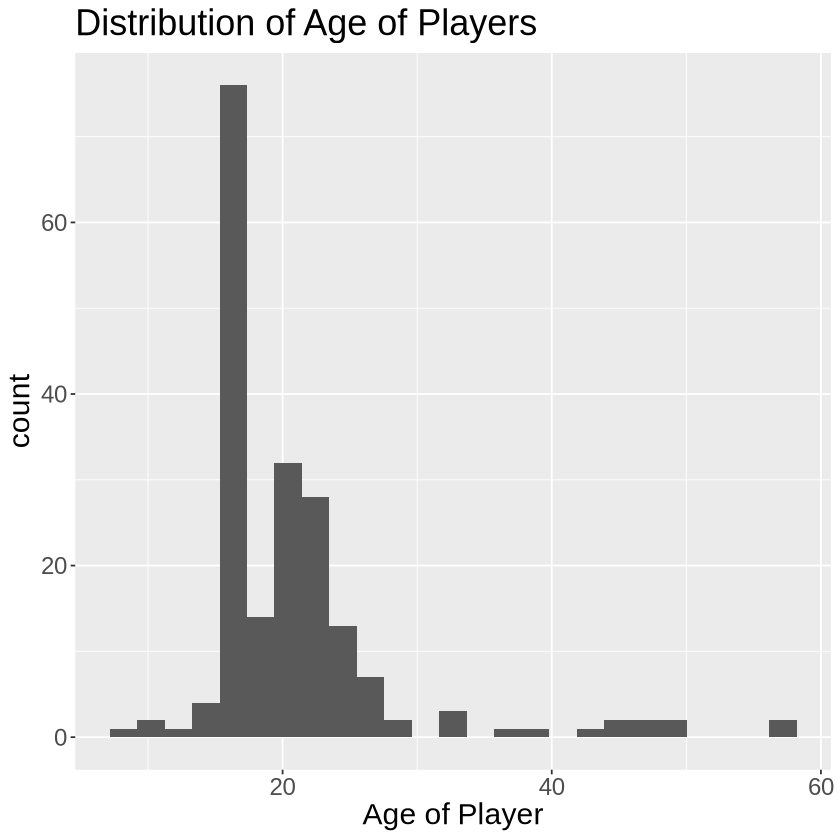

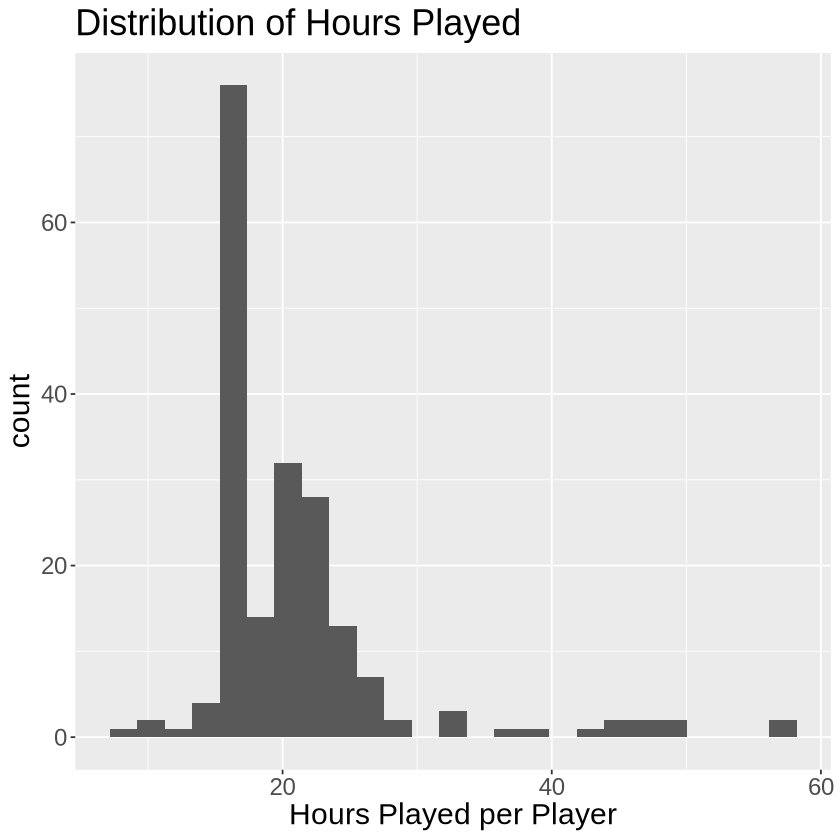

In [18]:
age_distribution <- tidy_players_info |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 25) +
    labs(x = 'Age of Player', title = 'Distribution of Age of Players') +
    theme(text = element_text(size = 18))

played_hours_distribution <- tidy_players_info |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 25) +
    labs(x = 'Hours Played per Player', title = 'Distribution of Hours Played') +
    theme(text = element_text(size = 18))

age_distribution
played_hours_distribution

## Results

##### Splitting Data

In [19]:
player_split <- initial_split(tidy_players_info, prop = 0.75, strata = subscribe)  
player_train <- training(player_split)   
player_test <- testing(player_split)

##### Building K-NN Classification Model

In [20]:
player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

player_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      fit(data = player_train)

Warning message:
“tune samples were requested but there were 145 rows in the data. 140 will be used.”


##### Tuning K

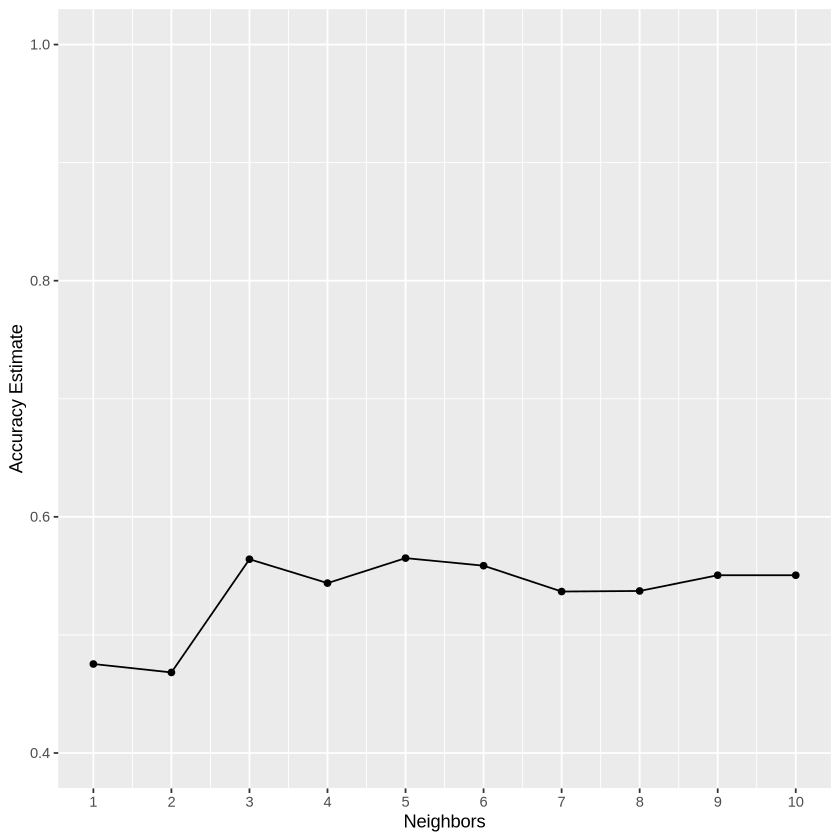

In [21]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_knn_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      tune_grid(resamples = player_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- player_knn_results |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) + # 
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot

We compare the cross-validation accuracy over a range of K values (from 1 to 10) in order to choose an appropriate value of K for our K-Nearest Neighbours model. There is a clear pattern in this accuracy vs. neighbors plot:

* K values that are very small-e.g., K = 1–3-produce lower, more unstable accuracy.

* As K increases, the accuracy becomes more consistent and starts to flatten out because adding extra neighbours does not alter the performance considerably.

* Around K = 9, the model gives one of the highest estimates of accuracy in the plot and belongs to a region that has attained stability in terms of accuracy.

It is preferable to choose a K in this flatter and more stable region since it reduces the chance that the model is overly sensitive to noise in the training data. In contrast, small values of K risk overfitting by relying too heavily on just a few of the nearest points.

Therefore, K = 9 was chosen, since it provides a good balance. It achieves strong accuracy compared to other K values tested. It also shows up in the stable high-accuracy region of the cross-validation curve and it avoids the variability and lower performance seen at smaller K values. This makes K=9 a reasonable and well-supported choice based on our cross-validation results.

##### Building Model with K = 9

In [22]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      fit(data = player_train)

##### Applying Model to Testing Set

In [23]:
player_predictions <- predict(player_fit, player_test) |>
                        bind_cols(player_test)
head(player_predictions)

player_metrics <- player_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class)

player_conf_matrix <- player_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
player_metrics
player_conf_matrix

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,1.5,25
TRUE,TRUE,0.2,22
FALSE,TRUE,0.0,17
TRUE,TRUE,48.4,17
FALSE,TRUE,0.6,19
FALSE,FALSE,0.1,18


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5714286
kap,binary,-0.1270537


          Truth
Prediction FALSE TRUE
     FALSE     2   10
     TRUE     11   26

##### Plotting Data Analysis

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


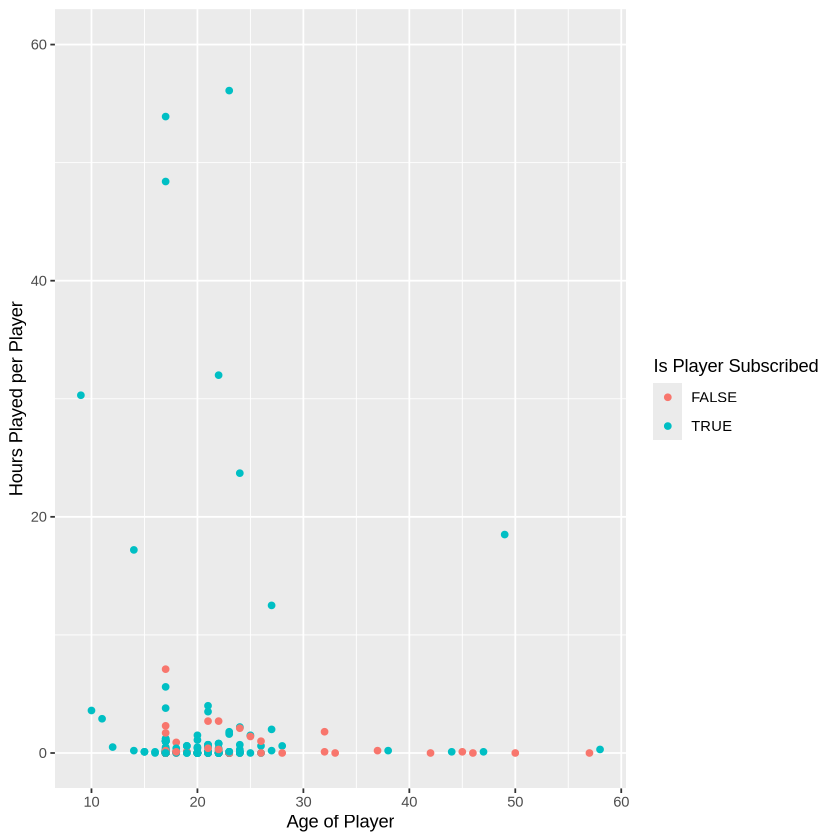

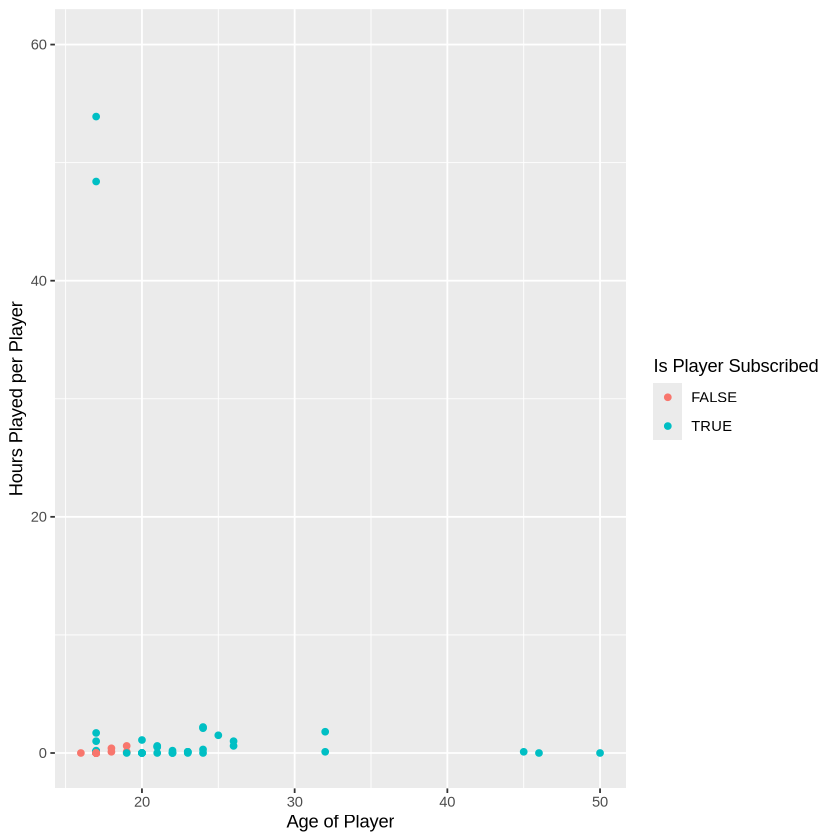

In [24]:
age_vs_played_hours <- tidy_players_info |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = 'Age of Player', y = 'Hours Played per Player', color = 'Is Player Subscribed') +
    ylim(0, 60) 
age_vs_played_hours

age_vs_played_hours_1 <- player_predictions |>
    ggplot(aes(x = Age, y = played_hours, color = .pred_class)) +
    geom_point() +
    labs(x = 'Age of Player', y = 'Hours Played per Player', color = 'Is Player Subscribed') +
    ylim(0, 60) 
age_vs_played_hours_1

## Discussion

- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to


The goal of this project was to determine whether a player's newsletter subscription status could be predicted from just two variables, age and hours played. After training and evaluating a classification model, the results show that these features are not strong predictors of whether someone subscribes to the game-related newsletter.

The model achieved an accuracy of about 57%, which is only slightly better than random guessing for a two-class problem. The confusion matrix shows that the model misclassified a substantial number of both subscribers and non-subscribers, further indicating that age and playtime alone do not provide enough information to distinguish between the two groups.